<a href="https://colab.research.google.com/github/sudhakarmlal/EVA/blob/master/Assignment25/assignment25_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 25 : Training Indian Car Images with GAN

## Contributed by:
* Monimoy Deb Purkayastha
* Chaitali Deb Purkayastha
* Sudhakar Reddy

In this assignment we have used DCGAN to train 1000 Indian Car Images. Indian Car Images are collected from internet and resized to 100x100 using https://bulkresizephotos.com/en

Base code is taken from https://github.com/eriklindernoren/Keras-GAN

- Modified the code to load images downloaded from internet
- Modified DCGAN model to take care of 100x100 and modified a few parameters
- Trained model for 5000 epochs
- Display the GAN generated car images at varous epochs

## Import all the library

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np


from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



E:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Write function to load car images in directory

- Write function get_training_images which takes image directory, size of image and batch size as images and returns a numpy array

In [0]:

def get_training_images(image_dir, target_size=(100,100), batch_size=1000):
    data_gen = ImageDataGenerator()
    data_generator = data_gen.flow_from_directory(
    image_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')
    data_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        data_list.append(data[0])
        batch_index = batch_index + 1
    data_array = np.asarray(data_list)
    return data_array


## Define DCGAN Model 

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 1024

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 25 * 25, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((25, 25, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=1, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=64, save_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()
        X_train = get_training_images('train')[0]
        print("X_train shape:" + str(X_train.shape))
        

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)
        print("X_train shape:" + str(X_train.shape))
        #System.exit(0)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/indian_cars_%d.png" % epoch)
        plt.close()



## Train DCGAN model for 5000 epochs

In [0]:
dcgan = DCGAN()
dcgan.train(epochs=5000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 51, 51, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 51, 51, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 51, 51, 64)        0         
__________

E:\anaconda\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 5.377243, acc.: 29.69%] [G loss: 0.044841]
1 [D loss: 0.304257, acc.: 92.19%] [G loss: 7.282604]
2 [D loss: 2.284536, acc.: 43.75%] [G loss: 1.505414]
3 [D loss: 1.316012, acc.: 39.06%] [G loss: 6.413666]
4 [D loss: 0.552871, acc.: 79.69%] [G loss: 5.153905]
5 [D loss: 0.406337, acc.: 81.25%] [G loss: 3.008354]
6 [D loss: 0.260232, acc.: 92.19%] [G loss: 3.750263]
7 [D loss: 0.323118, acc.: 85.94%] [G loss: 3.735318]
8 [D loss: 0.451904, acc.: 85.94%] [G loss: 3.439537]
9 [D loss: 0.164171, acc.: 89.06%] [G loss: 3.147772]
10 [D loss: 0.419833, acc.: 78.12%] [G loss: 3.160011]
11 [D loss: 0.358299, acc.: 84.38%] [G loss: 2.306159]
12 [D loss: 0.584946, acc.: 84.38%] [G loss: 1.752499]
13 [D loss: 0.289975, acc.: 89.06%] [G loss: 0.972971]
14 [D loss: 0.389826, acc.: 87.50%] [G loss: 1.539589]
15 [D loss: 0.119412, acc.: 98.44%] [G loss: 1.238449]
16 [D loss: 0.226302, acc.: 93.75%] [G loss: 3.375736]
17 [D loss: 1.109656, acc.: 42.19%] [G loss: 8.663738]
18 [D loss: 2.072721

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51 [D loss: 0.329373, acc.: 84.38%] [G loss: 9.706159]
52 [D loss: 3.599299, acc.: 20.31%] [G loss: 11.442693]
53 [D loss: 0.878300, acc.: 76.56%] [G loss: 6.185297]
54 [D loss: 0.011800, acc.: 100.00%] [G loss: 2.113075]
55 [D loss: 0.069429, acc.: 98.44%] [G loss: 1.380295]
56 [D loss: 0.172919, acc.: 92.19%] [G loss: 3.871406]
57 [D loss: 0.023446, acc.: 100.00%] [G loss: 5.553346]
58 [D loss: 0.563634, acc.: 82.81%] [G loss: 5.498881]
59 [D loss: 1.738836, acc.: 45.31%] [G loss: 13.119672]
60 [D loss: 2.984061, acc.: 31.25%] [G loss: 11.516903]
61 [D loss: 1.175796, acc.: 78.12%] [G loss: 2.299929]
62 [D loss: 1.647678, acc.: 53.12%] [G loss: 15.848937]
63 [D loss: 2.505920, acc.: 53.12%] [G loss: 2.911994]
64 [D loss: 0.677787, acc.: 82.81%] [G loss: 11.318233]
65 [D loss: 0.319106, acc.: 95.31%] [G loss: 14.509064]
66 [D loss: 1.530612, acc.: 70.31%] [G loss: 3.574401]
67 [D loss: 0.702653, acc.: 73.44%] [G loss: 12.001345]
68 [D loss: 0.644608, acc.: 81.25%] [G loss: 5.026239]
6

198 [D loss: 0.796345, acc.: 67.19%] [G loss: 2.291539]
199 [D loss: 0.359529, acc.: 85.94%] [G loss: 5.620951]
200 [D loss: 0.802785, acc.: 78.12%] [G loss: 3.234342]
201 [D loss: 0.805021, acc.: 67.19%] [G loss: 9.085873]
202 [D loss: 0.302310, acc.: 90.62%] [G loss: 5.955500]
203 [D loss: 0.525343, acc.: 79.69%] [G loss: 4.217330]
204 [D loss: 0.080809, acc.: 96.88%] [G loss: 4.367356]
205 [D loss: 0.055493, acc.: 96.88%] [G loss: 2.921294]
206 [D loss: 0.129749, acc.: 96.88%] [G loss: 2.199775]
207 [D loss: 0.197929, acc.: 92.19%] [G loss: 5.412363]
208 [D loss: 0.542652, acc.: 75.00%] [G loss: 4.916325]
209 [D loss: 0.243087, acc.: 90.62%] [G loss: 8.289702]
210 [D loss: 2.557460, acc.: 29.69%] [G loss: 13.476208]
211 [D loss: 3.385960, acc.: 39.06%] [G loss: 12.955261]
212 [D loss: 0.450084, acc.: 89.06%] [G loss: 12.242085]
213 [D loss: 0.129029, acc.: 96.88%] [G loss: 8.123507]
214 [D loss: 0.067486, acc.: 98.44%] [G loss: 4.802857]
215 [D loss: 0.026118, acc.: 98.44%] [G loss:

344 [D loss: 1.868443, acc.: 50.00%] [G loss: 1.463947]
345 [D loss: 0.157408, acc.: 96.88%] [G loss: 2.570213]
346 [D loss: 0.563803, acc.: 76.56%] [G loss: 8.012331]
347 [D loss: 1.808814, acc.: 51.56%] [G loss: 5.905240]
348 [D loss: 0.344533, acc.: 89.06%] [G loss: 7.597632]
349 [D loss: 0.586260, acc.: 79.69%] [G loss: 5.074196]
350 [D loss: 0.572762, acc.: 82.81%] [G loss: 7.668433]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


351 [D loss: 1.989727, acc.: 51.56%] [G loss: 3.409433]
352 [D loss: 0.054669, acc.: 96.88%] [G loss: 9.347816]
353 [D loss: 0.309368, acc.: 89.06%] [G loss: 7.186433]
354 [D loss: 0.245882, acc.: 89.06%] [G loss: 8.929296]
355 [D loss: 0.180328, acc.: 89.06%] [G loss: 7.436853]
356 [D loss: 0.772372, acc.: 71.88%] [G loss: 11.305294]
357 [D loss: 0.198966, acc.: 92.19%] [G loss: 10.462728]
358 [D loss: 0.133286, acc.: 93.75%] [G loss: 5.141128]
359 [D loss: 0.503434, acc.: 81.25%] [G loss: 8.598997]
360 [D loss: 0.440601, acc.: 78.12%] [G loss: 4.015149]
361 [D loss: 0.365002, acc.: 89.06%] [G loss: 8.038561]
362 [D loss: 0.541357, acc.: 78.12%] [G loss: 2.712418]
363 [D loss: 0.277985, acc.: 93.75%] [G loss: 5.667895]
364 [D loss: 0.065041, acc.: 96.88%] [G loss: 4.678216]
365 [D loss: 2.307681, acc.: 45.31%] [G loss: 13.406513]
366 [D loss: 4.242703, acc.: 48.44%] [G loss: 3.005768]
367 [D loss: 0.337176, acc.: 87.50%] [G loss: 4.762922]
368 [D loss: 0.069240, acc.: 96.88%] [G loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


401 [D loss: 0.143443, acc.: 95.31%] [G loss: 4.104725]
402 [D loss: 0.040096, acc.: 98.44%] [G loss: 4.280561]
403 [D loss: 0.309938, acc.: 85.94%] [G loss: 3.243318]
404 [D loss: 0.104899, acc.: 95.31%] [G loss: 4.197947]
405 [D loss: 0.351662, acc.: 82.81%] [G loss: 1.316326]
406 [D loss: 0.119263, acc.: 93.75%] [G loss: 1.555813]
407 [D loss: 0.081894, acc.: 96.88%] [G loss: 3.353733]
408 [D loss: 0.301922, acc.: 85.94%] [G loss: 4.095273]
409 [D loss: 0.083469, acc.: 96.88%] [G loss: 4.292654]
410 [D loss: 1.342651, acc.: 51.56%] [G loss: 11.907102]
411 [D loss: 0.845654, acc.: 78.12%] [G loss: 3.082123]
412 [D loss: 0.547333, acc.: 76.56%] [G loss: 12.204184]
413 [D loss: 1.582726, acc.: 56.25%] [G loss: 6.622160]
414 [D loss: 0.030777, acc.: 100.00%] [G loss: 9.548354]
415 [D loss: 5.872205, acc.: 14.06%] [G loss: 10.074333]
416 [D loss: 0.438585, acc.: 82.81%] [G loss: 10.792028]
417 [D loss: 2.656422, acc.: 40.62%] [G loss: 13.960785]
418 [D loss: 1.049361, acc.: 68.75%] [G lo

547 [D loss: 1.588916, acc.: 54.69%] [G loss: 3.855382]
548 [D loss: 0.026761, acc.: 98.44%] [G loss: 7.288114]
549 [D loss: 0.487173, acc.: 82.81%] [G loss: 7.402059]
550 [D loss: 0.071651, acc.: 96.88%] [G loss: 9.574422]
551 [D loss: 0.369044, acc.: 84.38%] [G loss: 4.343355]
552 [D loss: 0.211326, acc.: 93.75%] [G loss: 8.083432]
553 [D loss: 0.083731, acc.: 95.31%] [G loss: 8.243199]
554 [D loss: 1.846040, acc.: 48.44%] [G loss: 10.857578]
555 [D loss: 0.590908, acc.: 78.12%] [G loss: 4.930904]
556 [D loss: 0.611900, acc.: 81.25%] [G loss: 7.272954]
557 [D loss: 0.101075, acc.: 95.31%] [G loss: 6.511932]
558 [D loss: 0.120849, acc.: 95.31%] [G loss: 4.124594]
559 [D loss: 0.118137, acc.: 96.88%] [G loss: 4.559934]
560 [D loss: 0.149252, acc.: 96.88%] [G loss: 5.190565]
561 [D loss: 0.137131, acc.: 95.31%] [G loss: 3.677920]
562 [D loss: 0.241902, acc.: 92.19%] [G loss: 5.411007]
563 [D loss: 0.174300, acc.: 87.50%] [G loss: 6.749602]
564 [D loss: 0.386565, acc.: 87.50%] [G loss: 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


651 [D loss: 0.138568, acc.: 95.31%] [G loss: 5.036759]
652 [D loss: 1.762819, acc.: 48.44%] [G loss: 13.364651]
653 [D loss: 2.314993, acc.: 45.31%] [G loss: 4.786278]
654 [D loss: 0.269283, acc.: 85.94%] [G loss: 8.817646]
655 [D loss: 0.032243, acc.: 98.44%] [G loss: 9.428614]
656 [D loss: 0.527548, acc.: 82.81%] [G loss: 6.568058]
657 [D loss: 0.029635, acc.: 100.00%] [G loss: 6.482246]
658 [D loss: 0.058731, acc.: 100.00%] [G loss: 8.295424]
659 [D loss: 0.163710, acc.: 95.31%] [G loss: 7.673178]
660 [D loss: 0.045185, acc.: 98.44%] [G loss: 6.493392]
661 [D loss: 0.184768, acc.: 92.19%] [G loss: 5.713079]
662 [D loss: 0.038170, acc.: 100.00%] [G loss: 3.977772]
663 [D loss: 0.119066, acc.: 93.75%] [G loss: 7.545347]
664 [D loss: 0.283974, acc.: 85.94%] [G loss: 5.943331]
665 [D loss: 0.032906, acc.: 98.44%] [G loss: 6.588162]
666 [D loss: 0.136712, acc.: 95.31%] [G loss: 6.193338]
667 [D loss: 0.072078, acc.: 96.88%] [G loss: 5.195251]
668 [D loss: 0.156349, acc.: 95.31%] [G loss

797 [D loss: 0.051522, acc.: 96.88%] [G loss: 5.440905]
798 [D loss: 0.130467, acc.: 95.31%] [G loss: 5.917465]
799 [D loss: 0.017789, acc.: 100.00%] [G loss: 7.922934]
800 [D loss: 2.377932, acc.: 32.81%] [G loss: 12.056151]
801 [D loss: 0.588518, acc.: 82.81%] [G loss: 8.423971]
802 [D loss: 0.376585, acc.: 85.94%] [G loss: 8.707841]
803 [D loss: 0.038861, acc.: 96.88%] [G loss: 10.080877]
804 [D loss: 0.004417, acc.: 100.00%] [G loss: 9.519075]
805 [D loss: 0.029870, acc.: 98.44%] [G loss: 9.170403]
806 [D loss: 0.085970, acc.: 95.31%] [G loss: 7.255776]
807 [D loss: 0.030906, acc.: 100.00%] [G loss: 7.226904]
808 [D loss: 0.110892, acc.: 96.88%] [G loss: 6.085870]
809 [D loss: 0.050283, acc.: 98.44%] [G loss: 5.802983]
810 [D loss: 0.175595, acc.: 93.75%] [G loss: 3.962437]
811 [D loss: 0.173484, acc.: 92.19%] [G loss: 4.950069]
812 [D loss: 0.036074, acc.: 98.44%] [G loss: 6.603501]
813 [D loss: 0.178013, acc.: 95.31%] [G loss: 1.808465]
814 [D loss: 0.373021, acc.: 84.38%] [G los

943 [D loss: 0.097780, acc.: 96.88%] [G loss: 8.651480]
944 [D loss: 0.536402, acc.: 84.38%] [G loss: 7.173470]
945 [D loss: 0.153655, acc.: 96.88%] [G loss: 8.822870]
946 [D loss: 0.137465, acc.: 95.31%] [G loss: 10.003809]
947 [D loss: 0.048708, acc.: 98.44%] [G loss: 7.730387]
948 [D loss: 0.160778, acc.: 95.31%] [G loss: 10.471457]
949 [D loss: 0.004104, acc.: 100.00%] [G loss: 11.311977]
950 [D loss: 0.145592, acc.: 92.19%] [G loss: 4.057686]
951 [D loss: 0.448929, acc.: 81.25%] [G loss: 13.070484]
952 [D loss: 0.581438, acc.: 82.81%] [G loss: 4.530277]
953 [D loss: 0.154249, acc.: 92.19%] [G loss: 8.788338]
954 [D loss: 0.024727, acc.: 98.44%] [G loss: 10.675688]
955 [D loss: 0.045807, acc.: 100.00%] [G loss: 8.133257]
956 [D loss: 0.110470, acc.: 95.31%] [G loss: 5.737385]
957 [D loss: 0.100145, acc.: 96.88%] [G loss: 5.596280]
958 [D loss: 0.071386, acc.: 98.44%] [G loss: 5.911094]
959 [D loss: 0.499245, acc.: 85.94%] [G loss: 3.543526]
960 [D loss: 0.045743, acc.: 98.44%] [G l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1001 [D loss: 0.011126, acc.: 100.00%] [G loss: 6.690175]
1002 [D loss: 0.113784, acc.: 95.31%] [G loss: 8.047502]
1003 [D loss: 0.047437, acc.: 98.44%] [G loss: 8.727994]
1004 [D loss: 0.122399, acc.: 95.31%] [G loss: 5.189826]
1005 [D loss: 0.054085, acc.: 96.88%] [G loss: 7.078197]
1006 [D loss: 0.002276, acc.: 100.00%] [G loss: 8.336061]
1007 [D loss: 0.070318, acc.: 98.44%] [G loss: 4.173176]
1008 [D loss: 0.579090, acc.: 76.56%] [G loss: 12.992302]
1009 [D loss: 0.324040, acc.: 87.50%] [G loss: 10.481802]
1010 [D loss: 0.244837, acc.: 90.62%] [G loss: 6.197677]
1011 [D loss: 0.188609, acc.: 93.75%] [G loss: 7.947238]
1012 [D loss: 0.893117, acc.: 57.81%] [G loss: 12.861643]
1013 [D loss: 3.031373, acc.: 23.44%] [G loss: 14.139759]
1014 [D loss: 4.426033, acc.: 23.44%] [G loss: 15.243840]
1015 [D loss: 8.229822, acc.: 7.81%] [G loss: 10.253283]
1016 [D loss: 0.562505, acc.: 85.94%] [G loss: 11.943546]
1017 [D loss: 4.605051, acc.: 23.44%] [G loss: 10.755544]
1018 [D loss: 0.643039

1144 [D loss: 0.173502, acc.: 93.75%] [G loss: 8.141744]
1145 [D loss: 0.109045, acc.: 95.31%] [G loss: 11.161331]
1146 [D loss: 0.481591, acc.: 79.69%] [G loss: 5.493144]
1147 [D loss: 0.139440, acc.: 93.75%] [G loss: 7.592963]
1148 [D loss: 0.073185, acc.: 96.88%] [G loss: 8.142979]
1149 [D loss: 0.142184, acc.: 95.31%] [G loss: 8.687653]
1150 [D loss: 0.193280, acc.: 92.19%] [G loss: 6.895354]
1151 [D loss: 0.098995, acc.: 96.88%] [G loss: 8.577196]
1152 [D loss: 0.004722, acc.: 100.00%] [G loss: 10.446333]
1153 [D loss: 0.229226, acc.: 90.62%] [G loss: 6.323160]
1154 [D loss: 0.075099, acc.: 98.44%] [G loss: 6.125248]
1155 [D loss: 0.039693, acc.: 98.44%] [G loss: 7.615838]
1156 [D loss: 0.053777, acc.: 98.44%] [G loss: 6.951240]
1157 [D loss: 0.003430, acc.: 100.00%] [G loss: 7.260490]
1158 [D loss: 0.031173, acc.: 100.00%] [G loss: 7.068570]
1159 [D loss: 0.074759, acc.: 96.88%] [G loss: 7.117324]
1160 [D loss: 0.012071, acc.: 100.00%] [G loss: 7.289123]
1161 [D loss: 0.118425, a

1287 [D loss: 0.017931, acc.: 100.00%] [G loss: 9.616299]
1288 [D loss: 0.313252, acc.: 87.50%] [G loss: 6.824926]
1289 [D loss: 0.083414, acc.: 95.31%] [G loss: 10.579506]
1290 [D loss: 1.780478, acc.: 40.62%] [G loss: 14.823186]
1291 [D loss: 0.994014, acc.: 68.75%] [G loss: 5.824018]
1292 [D loss: 0.119451, acc.: 96.88%] [G loss: 8.306704]
1293 [D loss: 0.159436, acc.: 92.19%] [G loss: 10.049603]
1294 [D loss: 0.787902, acc.: 71.88%] [G loss: 12.091327]
1295 [D loss: 0.725021, acc.: 85.94%] [G loss: 7.405174]
1296 [D loss: 0.138316, acc.: 93.75%] [G loss: 10.403588]
1297 [D loss: 0.162748, acc.: 93.75%] [G loss: 9.281458]
1298 [D loss: 0.567398, acc.: 82.81%] [G loss: 8.959732]
1299 [D loss: 0.015633, acc.: 100.00%] [G loss: 9.345521]
1300 [D loss: 0.120235, acc.: 93.75%] [G loss: 6.002852]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1301 [D loss: 0.037565, acc.: 98.44%] [G loss: 7.685341]
1302 [D loss: 0.033515, acc.: 98.44%] [G loss: 8.229862]
1303 [D loss: 0.037913, acc.: 98.44%] [G loss: 9.256511]
1304 [D loss: 0.136962, acc.: 96.88%] [G loss: 9.080954]
1305 [D loss: 0.070474, acc.: 96.88%] [G loss: 7.973019]
1306 [D loss: 0.046233, acc.: 96.88%] [G loss: 7.550987]
1307 [D loss: 0.207471, acc.: 93.75%] [G loss: 7.771625]
1308 [D loss: 0.868896, acc.: 70.31%] [G loss: 10.542238]
1309 [D loss: 0.054804, acc.: 96.88%] [G loss: 12.476515]
1310 [D loss: 0.112150, acc.: 95.31%] [G loss: 7.487040]
1311 [D loss: 0.133243, acc.: 95.31%] [G loss: 8.758917]
1312 [D loss: 0.075875, acc.: 98.44%] [G loss: 8.763193]
1313 [D loss: 0.444352, acc.: 85.94%] [G loss: 7.971360]
1314 [D loss: 0.089662, acc.: 95.31%] [G loss: 9.419811]
1315 [D loss: 0.108558, acc.: 93.75%] [G loss: 7.928714]
1316 [D loss: 0.066124, acc.: 96.88%] [G loss: 9.560676]
1317 [D loss: 1.520352, acc.: 53.12%] [G loss: 14.465931]
1318 [D loss: 0.304649, acc.

1444 [D loss: 0.069263, acc.: 98.44%] [G loss: 9.040043]
1445 [D loss: 0.031673, acc.: 98.44%] [G loss: 9.986642]
1446 [D loss: 0.662500, acc.: 76.56%] [G loss: 9.971497]
1447 [D loss: 0.054520, acc.: 98.44%] [G loss: 12.208233]
1448 [D loss: 1.243388, acc.: 53.12%] [G loss: 9.697834]
1449 [D loss: 0.121727, acc.: 98.44%] [G loss: 10.854666]
1450 [D loss: 0.232791, acc.: 90.62%] [G loss: 7.005509]
1451 [D loss: 0.953304, acc.: 68.75%] [G loss: 13.722773]
1452 [D loss: 1.041270, acc.: 70.31%] [G loss: 6.086672]
1453 [D loss: 0.105961, acc.: 92.19%] [G loss: 8.643841]
1454 [D loss: 0.247228, acc.: 90.62%] [G loss: 7.284502]
1455 [D loss: 0.355639, acc.: 87.50%] [G loss: 8.116009]
1456 [D loss: 0.002377, acc.: 100.00%] [G loss: 11.412403]
1457 [D loss: 0.699760, acc.: 78.12%] [G loss: 7.497658]
1458 [D loss: 0.291918, acc.: 89.06%] [G loss: 7.168081]
1459 [D loss: 0.150746, acc.: 96.88%] [G loss: 8.436630]
1460 [D loss: 0.014983, acc.: 100.00%] [G loss: 7.004932]
1461 [D loss: 0.059149, a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1551 [D loss: 0.216755, acc.: 89.06%] [G loss: 9.335136]
1552 [D loss: 0.844997, acc.: 71.88%] [G loss: 9.812456]
1553 [D loss: 0.011381, acc.: 100.00%] [G loss: 12.583418]
1554 [D loss: 0.092635, acc.: 96.88%] [G loss: 8.324781]
1555 [D loss: 0.071587, acc.: 96.88%] [G loss: 9.373335]
1556 [D loss: 0.019607, acc.: 98.44%] [G loss: 9.768437]
1557 [D loss: 0.085457, acc.: 95.31%] [G loss: 7.799511]
1558 [D loss: 0.022045, acc.: 98.44%] [G loss: 8.345010]
1559 [D loss: 0.015416, acc.: 100.00%] [G loss: 8.095455]
1560 [D loss: 0.047946, acc.: 98.44%] [G loss: 9.012561]
1561 [D loss: 0.293966, acc.: 89.06%] [G loss: 8.512936]
1562 [D loss: 0.048603, acc.: 98.44%] [G loss: 8.228649]
1563 [D loss: 0.055113, acc.: 98.44%] [G loss: 7.404402]
1564 [D loss: 0.119154, acc.: 95.31%] [G loss: 8.344028]
1565 [D loss: 0.107759, acc.: 95.31%] [G loss: 7.561794]
1566 [D loss: 0.015320, acc.: 100.00%] [G loss: 7.138603]
1567 [D loss: 0.016231, acc.: 98.44%] [G loss: 8.033984]
1568 [D loss: 0.049614, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1651 [D loss: 0.145501, acc.: 93.75%] [G loss: 8.792477]
1652 [D loss: 0.138070, acc.: 93.75%] [G loss: 6.553997]
1653 [D loss: 0.057976, acc.: 96.88%] [G loss: 8.232970]
1654 [D loss: 0.065453, acc.: 98.44%] [G loss: 8.714838]
1655 [D loss: 0.159667, acc.: 90.62%] [G loss: 8.405988]
1656 [D loss: 0.109990, acc.: 93.75%] [G loss: 8.197320]
1657 [D loss: 0.182800, acc.: 93.75%] [G loss: 6.961671]
1658 [D loss: 0.032412, acc.: 98.44%] [G loss: 8.127968]
1659 [D loss: 0.528774, acc.: 78.12%] [G loss: 8.840170]
1660 [D loss: 0.120215, acc.: 93.75%] [G loss: 10.057695]
1661 [D loss: 0.098484, acc.: 93.75%] [G loss: 8.191107]
1662 [D loss: 0.043094, acc.: 98.44%] [G loss: 6.778711]
1663 [D loss: 0.173664, acc.: 90.62%] [G loss: 5.041913]
1664 [D loss: 0.048009, acc.: 98.44%] [G loss: 7.533724]
1665 [D loss: 0.162963, acc.: 95.31%] [G loss: 6.649191]
1666 [D loss: 0.166925, acc.: 93.75%] [G loss: 6.841187]
1667 [D loss: 0.067353, acc.: 96.88%] [G loss: 5.500477]
1668 [D loss: 0.018007, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1701 [D loss: 0.214381, acc.: 92.19%] [G loss: 11.040260]
1702 [D loss: 2.285563, acc.: 37.50%] [G loss: 15.114500]
1703 [D loss: 1.298955, acc.: 68.75%] [G loss: 4.092283]
1704 [D loss: 0.490027, acc.: 79.69%] [G loss: 14.257755]
1705 [D loss: 0.600026, acc.: 84.38%] [G loss: 9.426846]
1706 [D loss: 0.296243, acc.: 87.50%] [G loss: 9.228065]
1707 [D loss: 0.020154, acc.: 100.00%] [G loss: 10.999260]
1708 [D loss: 0.849936, acc.: 73.44%] [G loss: 5.841841]
1709 [D loss: 0.408966, acc.: 84.38%] [G loss: 13.419369]
1710 [D loss: 0.475405, acc.: 87.50%] [G loss: 8.938446]
1711 [D loss: 0.479559, acc.: 89.06%] [G loss: 13.048668]
1712 [D loss: 0.351403, acc.: 85.94%] [G loss: 10.903221]
1713 [D loss: 1.209560, acc.: 67.19%] [G loss: 14.794257]
1714 [D loss: 0.939626, acc.: 68.75%] [G loss: 6.913702]
1715 [D loss: 0.206683, acc.: 93.75%] [G loss: 11.012345]
1716 [D loss: 0.094891, acc.: 96.88%] [G loss: 10.220413]
1717 [D loss: 0.230997, acc.: 89.06%] [G loss: 7.920259]
1718 [D loss: 0.1078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1751 [D loss: 0.282407, acc.: 85.94%] [G loss: 7.648745]
1752 [D loss: 0.202506, acc.: 95.31%] [G loss: 8.720175]
1753 [D loss: 0.100414, acc.: 96.88%] [G loss: 11.136862]
1754 [D loss: 0.104710, acc.: 95.31%] [G loss: 6.919377]
1755 [D loss: 0.082070, acc.: 95.31%] [G loss: 8.057550]
1756 [D loss: 0.028296, acc.: 98.44%] [G loss: 9.798187]
1757 [D loss: 0.124625, acc.: 95.31%] [G loss: 6.746634]
1758 [D loss: 0.039899, acc.: 100.00%] [G loss: 7.794021]
1759 [D loss: 0.171667, acc.: 92.19%] [G loss: 10.581042]
1760 [D loss: 0.121187, acc.: 95.31%] [G loss: 7.669912]
1761 [D loss: 0.132637, acc.: 93.75%] [G loss: 9.742130]
1762 [D loss: 0.074981, acc.: 98.44%] [G loss: 11.047576]
1763 [D loss: 1.192823, acc.: 62.50%] [G loss: 13.744827]
1764 [D loss: 0.281749, acc.: 89.06%] [G loss: 10.234258]
1765 [D loss: 0.051812, acc.: 96.88%] [G loss: 7.300055]
1766 [D loss: 0.035310, acc.: 98.44%] [G loss: 8.952942]
1767 [D loss: 0.001881, acc.: 100.00%] [G loss: 9.187935]
1768 [D loss: 0.136276, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1801 [D loss: 0.653353, acc.: 76.56%] [G loss: 10.700833]
1802 [D loss: 0.003955, acc.: 100.00%] [G loss: 13.537443]
1803 [D loss: 0.506994, acc.: 79.69%] [G loss: 4.605931]
1804 [D loss: 1.056027, acc.: 76.56%] [G loss: 15.964823]
1805 [D loss: 3.861289, acc.: 31.25%] [G loss: 15.052547]
1806 [D loss: 9.955091, acc.: 12.50%] [G loss: 12.864016]
1807 [D loss: 3.777876, acc.: 64.06%] [G loss: 12.877615]
1808 [D loss: 3.386342, acc.: 56.25%] [G loss: 14.587152]
1809 [D loss: 3.426179, acc.: 54.69%] [G loss: 11.043831]
1810 [D loss: 3.478531, acc.: 46.88%] [G loss: 12.045354]
1811 [D loss: 2.252653, acc.: 57.81%] [G loss: 12.999743]
1812 [D loss: 2.437508, acc.: 67.19%] [G loss: 4.720335]
1813 [D loss: 0.303624, acc.: 92.19%] [G loss: 6.281075]
1814 [D loss: 0.421399, acc.: 81.25%] [G loss: 8.179928]
1815 [D loss: 0.971010, acc.: 73.44%] [G loss: 1.215245]
1816 [D loss: 1.257851, acc.: 75.00%] [G loss: 14.356984]
1817 [D loss: 5.718220, acc.: 26.56%] [G loss: 8.092283]
1818 [D loss: 0.502

1944 [D loss: 1.219298, acc.: 62.50%] [G loss: 11.723731]
1945 [D loss: 0.027498, acc.: 98.44%] [G loss: 14.820375]
1946 [D loss: 0.588086, acc.: 85.94%] [G loss: 5.577366]
1947 [D loss: 0.695136, acc.: 85.94%] [G loss: 12.856415]
1948 [D loss: 0.067027, acc.: 98.44%] [G loss: 14.443571]
1949 [D loss: 2.869042, acc.: 28.12%] [G loss: 15.133400]
1950 [D loss: 0.487932, acc.: 85.94%] [G loss: 13.579409]
1951 [D loss: 0.221951, acc.: 89.06%] [G loss: 7.093268]
1952 [D loss: 0.110631, acc.: 92.19%] [G loss: 10.697904]
1953 [D loss: 0.051361, acc.: 96.88%] [G loss: 13.189182]
1954 [D loss: 0.243336, acc.: 90.62%] [G loss: 8.912048]
1955 [D loss: 0.195017, acc.: 95.31%] [G loss: 8.622697]
1956 [D loss: 0.008051, acc.: 100.00%] [G loss: 12.063679]
1957 [D loss: 0.079923, acc.: 96.88%] [G loss: 10.635236]
1958 [D loss: 0.159491, acc.: 90.62%] [G loss: 8.915797]
1959 [D loss: 0.024181, acc.: 100.00%] [G loss: 8.205770]
1960 [D loss: 0.114661, acc.: 95.31%] [G loss: 7.454621]
1961 [D loss: 0.122

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2001 [D loss: 0.013461, acc.: 100.00%] [G loss: 8.284418]
2002 [D loss: 0.016716, acc.: 100.00%] [G loss: 9.750126]
2003 [D loss: 0.026555, acc.: 98.44%] [G loss: 7.856508]
2004 [D loss: 0.011862, acc.: 100.00%] [G loss: 8.466708]
2005 [D loss: 0.018849, acc.: 100.00%] [G loss: 9.017880]
2006 [D loss: 0.046884, acc.: 96.88%] [G loss: 9.816773]
2007 [D loss: 0.087261, acc.: 98.44%] [G loss: 8.600660]
2008 [D loss: 0.036461, acc.: 98.44%] [G loss: 9.918446]
2009 [D loss: 0.003485, acc.: 100.00%] [G loss: 8.638268]
2010 [D loss: 0.003772, acc.: 100.00%] [G loss: 9.646652]
2011 [D loss: 0.095342, acc.: 96.88%] [G loss: 9.521044]
2012 [D loss: 0.027783, acc.: 100.00%] [G loss: 8.195108]
2013 [D loss: 0.151051, acc.: 92.19%] [G loss: 8.881295]
2014 [D loss: 0.031306, acc.: 98.44%] [G loss: 9.576954]
2015 [D loss: 0.049142, acc.: 96.88%] [G loss: 9.719795]
2016 [D loss: 0.074245, acc.: 98.44%] [G loss: 9.986802]
2017 [D loss: 0.011672, acc.: 100.00%] [G loss: 9.526465]
2018 [D loss: 0.045030,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2101 [D loss: 0.274000, acc.: 87.50%] [G loss: 7.235515]
2102 [D loss: 0.037288, acc.: 96.88%] [G loss: 9.568840]
2103 [D loss: 0.156298, acc.: 93.75%] [G loss: 6.922933]
2104 [D loss: 0.176897, acc.: 92.19%] [G loss: 10.398876]
2105 [D loss: 0.006120, acc.: 100.00%] [G loss: 11.923719]
2106 [D loss: 0.512528, acc.: 85.94%] [G loss: 5.514251]
2107 [D loss: 0.094788, acc.: 96.88%] [G loss: 8.685071]
2108 [D loss: 0.224438, acc.: 92.19%] [G loss: 10.492958]
2109 [D loss: 0.230411, acc.: 93.75%] [G loss: 7.467749]
2110 [D loss: 0.045184, acc.: 98.44%] [G loss: 9.964853]
2111 [D loss: 0.053601, acc.: 98.44%] [G loss: 9.988701]
2112 [D loss: 0.351594, acc.: 87.50%] [G loss: 7.301456]
2113 [D loss: 0.105910, acc.: 95.31%] [G loss: 10.256206]
2114 [D loss: 0.100504, acc.: 96.88%] [G loss: 7.594677]
2115 [D loss: 0.391375, acc.: 82.81%] [G loss: 8.934061]
2116 [D loss: 0.051041, acc.: 98.44%] [G loss: 12.226343]
2117 [D loss: 0.125420, acc.: 96.88%] [G loss: 10.297581]
2118 [D loss: 0.079272, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2201 [D loss: 0.150968, acc.: 93.75%] [G loss: 9.183472]
2202 [D loss: 0.106846, acc.: 95.31%] [G loss: 6.891540]
2203 [D loss: 0.060539, acc.: 95.31%] [G loss: 8.666368]
2204 [D loss: 0.046417, acc.: 100.00%] [G loss: 5.873924]
2205 [D loss: 0.099357, acc.: 93.75%] [G loss: 8.686756]
2206 [D loss: 0.164698, acc.: 90.62%] [G loss: 6.381283]
2207 [D loss: 0.148247, acc.: 93.75%] [G loss: 9.911795]
2208 [D loss: 1.599757, acc.: 54.69%] [G loss: 14.222515]
2209 [D loss: 0.513598, acc.: 87.50%] [G loss: 10.838043]
2210 [D loss: 1.591713, acc.: 62.50%] [G loss: 15.898010]
2211 [D loss: 0.555150, acc.: 79.69%] [G loss: 8.206486]
2212 [D loss: 0.035269, acc.: 98.44%] [G loss: 11.120891]
2213 [D loss: 0.109395, acc.: 95.31%] [G loss: 10.347268]
2214 [D loss: 0.162821, acc.: 98.44%] [G loss: 9.648420]
2215 [D loss: 0.050235, acc.: 96.88%] [G loss: 11.764521]
2216 [D loss: 0.342988, acc.: 89.06%] [G loss: 10.216135]
2217 [D loss: 0.196874, acc.: 90.62%] [G loss: 8.305109]
2218 [D loss: 0.109898,

2344 [D loss: 0.061166, acc.: 96.88%] [G loss: 8.229067]
2345 [D loss: 0.007508, acc.: 100.00%] [G loss: 8.969634]
2346 [D loss: 0.020088, acc.: 100.00%] [G loss: 10.060574]
2347 [D loss: 0.081784, acc.: 95.31%] [G loss: 10.018966]
2348 [D loss: 0.205416, acc.: 93.75%] [G loss: 7.282469]
2349 [D loss: 0.127886, acc.: 93.75%] [G loss: 10.750805]
2350 [D loss: 0.095353, acc.: 95.31%] [G loss: 10.867652]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2351 [D loss: 0.788616, acc.: 78.12%] [G loss: 13.061251]
2352 [D loss: 0.025621, acc.: 98.44%] [G loss: 12.555279]
2353 [D loss: 0.615703, acc.: 78.12%] [G loss: 13.419176]
2354 [D loss: 0.064190, acc.: 96.88%] [G loss: 12.717289]
2355 [D loss: 1.936278, acc.: 57.81%] [G loss: 15.245733]
2356 [D loss: 0.358406, acc.: 87.50%] [G loss: 11.806162]
2357 [D loss: 0.165083, acc.: 92.19%] [G loss: 5.067168]
2358 [D loss: 0.216942, acc.: 93.75%] [G loss: 9.338740]
2359 [D loss: 0.079400, acc.: 95.31%] [G loss: 9.328639]
2360 [D loss: 0.121316, acc.: 93.75%] [G loss: 5.382043]
2361 [D loss: 0.438321, acc.: 82.81%] [G loss: 9.085333]
2362 [D loss: 0.129345, acc.: 93.75%] [G loss: 9.676985]
2363 [D loss: 0.444706, acc.: 84.38%] [G loss: 10.280436]
2364 [D loss: 0.159489, acc.: 90.62%] [G loss: 9.318117]
2365 [D loss: 0.183755, acc.: 92.19%] [G loss: 11.059553]
2366 [D loss: 0.275897, acc.: 92.19%] [G loss: 8.863592]
2367 [D loss: 0.025009, acc.: 100.00%] [G loss: 11.490942]
2368 [D loss: 0.09105

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2451 [D loss: 0.758148, acc.: 84.38%] [G loss: 15.559750]
2452 [D loss: 0.794466, acc.: 75.00%] [G loss: 11.286253]
2453 [D loss: 0.056988, acc.: 98.44%] [G loss: 11.319723]
2454 [D loss: 3.497291, acc.: 42.19%] [G loss: 15.236534]
2455 [D loss: 0.501208, acc.: 89.06%] [G loss: 15.844066]
2456 [D loss: 1.577354, acc.: 60.94%] [G loss: 12.212122]
2457 [D loss: 4.850788, acc.: 34.38%] [G loss: 15.476388]
2458 [D loss: 0.533166, acc.: 81.25%] [G loss: 4.005196]
2459 [D loss: 0.438655, acc.: 82.81%] [G loss: 15.323701]
2460 [D loss: 6.209144, acc.: 14.06%] [G loss: 13.946115]
2461 [D loss: 1.399536, acc.: 78.12%] [G loss: 9.508003]
2462 [D loss: 0.837833, acc.: 84.38%] [G loss: 9.525434]
2463 [D loss: 0.129349, acc.: 96.88%] [G loss: 11.784914]
2464 [D loss: 0.322998, acc.: 87.50%] [G loss: 9.289080]
2465 [D loss: 0.133740, acc.: 96.88%] [G loss: 7.741963]
2466 [D loss: 0.638224, acc.: 82.81%] [G loss: 14.876511]
2467 [D loss: 0.418188, acc.: 85.94%] [G loss: 9.621786]
2468 [D loss: 0.0335

2594 [D loss: 0.053493, acc.: 96.88%] [G loss: 9.441932]
2595 [D loss: 0.036850, acc.: 98.44%] [G loss: 10.600887]
2596 [D loss: 0.109735, acc.: 96.88%] [G loss: 9.168031]
2597 [D loss: 0.119546, acc.: 93.75%] [G loss: 9.978209]
2598 [D loss: 0.132450, acc.: 96.88%] [G loss: 10.491753]
2599 [D loss: 0.053042, acc.: 98.44%] [G loss: 9.856630]
2600 [D loss: 0.095696, acc.: 96.88%] [G loss: 9.390094]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2601 [D loss: 0.004778, acc.: 100.00%] [G loss: 9.338027]
2602 [D loss: 0.334168, acc.: 84.38%] [G loss: 9.361536]
2603 [D loss: 0.070193, acc.: 98.44%] [G loss: 13.454172]
2604 [D loss: 0.010469, acc.: 100.00%] [G loss: 15.040691]
2605 [D loss: 0.058822, acc.: 96.88%] [G loss: 12.106802]
2606 [D loss: 0.260064, acc.: 92.19%] [G loss: 8.189766]
2607 [D loss: 0.191495, acc.: 93.75%] [G loss: 11.509205]
2608 [D loss: 0.040417, acc.: 95.31%] [G loss: 12.299612]
2609 [D loss: 0.440967, acc.: 87.50%] [G loss: 8.114841]
2610 [D loss: 0.171560, acc.: 93.75%] [G loss: 12.000336]
2611 [D loss: 0.106283, acc.: 95.31%] [G loss: 10.768973]
2612 [D loss: 0.097844, acc.: 93.75%] [G loss: 12.535843]
2613 [D loss: 0.030393, acc.: 100.00%] [G loss: 9.367948]
2614 [D loss: 0.018777, acc.: 98.44%] [G loss: 8.103936]
2615 [D loss: 0.022198, acc.: 100.00%] [G loss: 7.991819]
2616 [D loss: 0.016392, acc.: 98.44%] [G loss: 9.535503]
2617 [D loss: 0.006964, acc.: 100.00%] [G loss: 8.852205]
2618 [D loss: 0.03

2743 [D loss: 0.053375, acc.: 96.88%] [G loss: 10.129181]
2744 [D loss: 0.067414, acc.: 96.88%] [G loss: 9.983858]
2745 [D loss: 0.099017, acc.: 96.88%] [G loss: 10.045534]
2746 [D loss: 0.060394, acc.: 96.88%] [G loss: 11.184816]
2747 [D loss: 0.075231, acc.: 96.88%] [G loss: 9.072578]
2748 [D loss: 0.130903, acc.: 95.31%] [G loss: 8.351059]
2749 [D loss: 0.053643, acc.: 96.88%] [G loss: 9.629351]
2750 [D loss: 0.448709, acc.: 87.50%] [G loss: 9.390461]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2751 [D loss: 0.084636, acc.: 96.88%] [G loss: 7.315087]
2752 [D loss: 0.063938, acc.: 98.44%] [G loss: 10.565580]
2753 [D loss: 0.232916, acc.: 92.19%] [G loss: 7.837844]
2754 [D loss: 0.020764, acc.: 100.00%] [G loss: 9.327068]
2755 [D loss: 0.029106, acc.: 100.00%] [G loss: 12.116326]
2756 [D loss: 0.104218, acc.: 93.75%] [G loss: 11.402686]
2757 [D loss: 0.038856, acc.: 100.00%] [G loss: 8.475659]
2758 [D loss: 0.067646, acc.: 98.44%] [G loss: 8.525813]
2759 [D loss: 0.125129, acc.: 96.88%] [G loss: 9.112908]
2760 [D loss: 0.029268, acc.: 98.44%] [G loss: 10.384718]
2761 [D loss: 0.013392, acc.: 100.00%] [G loss: 7.985663]
2762 [D loss: 0.103267, acc.: 98.44%] [G loss: 9.863852]
2763 [D loss: 0.119780, acc.: 96.88%] [G loss: 10.363400]
2764 [D loss: 0.156913, acc.: 95.31%] [G loss: 8.811426]
2765 [D loss: 0.130214, acc.: 93.75%] [G loss: 11.121804]
2766 [D loss: 0.011717, acc.: 100.00%] [G loss: 11.324823]
2767 [D loss: 0.143032, acc.: 93.75%] [G loss: 8.842685]
2768 [D loss: 0.067

2893 [D loss: 0.195094, acc.: 89.06%] [G loss: 7.921740]
2894 [D loss: 0.067948, acc.: 95.31%] [G loss: 10.462573]
2895 [D loss: 0.182151, acc.: 95.31%] [G loss: 9.255131]
2896 [D loss: 0.101294, acc.: 96.88%] [G loss: 9.935996]
2897 [D loss: 0.071920, acc.: 96.88%] [G loss: 11.644250]
2898 [D loss: 0.023842, acc.: 98.44%] [G loss: 9.308137]
2899 [D loss: 0.120357, acc.: 93.75%] [G loss: 9.529496]
2900 [D loss: 0.027991, acc.: 100.00%] [G loss: 10.168030]
2901 [D loss: 0.017739, acc.: 100.00%] [G loss: 10.704802]
2902 [D loss: 0.078643, acc.: 96.88%] [G loss: 10.109500]
2903 [D loss: 0.025335, acc.: 100.00%] [G loss: 12.657443]
2904 [D loss: 0.154368, acc.: 92.19%] [G loss: 10.380287]
2905 [D loss: 0.114601, acc.: 95.31%] [G loss: 10.056352]
2906 [D loss: 0.055968, acc.: 96.88%] [G loss: 9.537992]
2907 [D loss: 0.005536, acc.: 100.00%] [G loss: 9.820368]
2908 [D loss: 0.040675, acc.: 96.88%] [G loss: 8.849730]
2909 [D loss: 0.041998, acc.: 98.44%] [G loss: 10.570774]
2910 [D loss: 0.02

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3001 [D loss: 0.003150, acc.: 100.00%] [G loss: 13.644968]
3002 [D loss: 0.041430, acc.: 98.44%] [G loss: 8.891193]
3003 [D loss: 0.013832, acc.: 100.00%] [G loss: 9.722359]
3004 [D loss: 0.086140, acc.: 98.44%] [G loss: 10.930439]
3005 [D loss: 0.047947, acc.: 96.88%] [G loss: 11.226926]
3006 [D loss: 0.009597, acc.: 100.00%] [G loss: 10.508343]
3007 [D loss: 0.003895, acc.: 100.00%] [G loss: 10.493110]
3008 [D loss: 0.009821, acc.: 100.00%] [G loss: 8.569521]
3009 [D loss: 0.151094, acc.: 98.44%] [G loss: 9.087182]
3010 [D loss: 0.029809, acc.: 98.44%] [G loss: 9.183261]
3011 [D loss: 0.015555, acc.: 100.00%] [G loss: 9.151318]
3012 [D loss: 0.006508, acc.: 100.00%] [G loss: 10.245325]
3013 [D loss: 0.010046, acc.: 100.00%] [G loss: 8.881733]
3014 [D loss: 0.300307, acc.: 89.06%] [G loss: 11.124845]
3015 [D loss: 0.234234, acc.: 96.88%] [G loss: 9.835989]
3016 [D loss: 0.031257, acc.: 100.00%] [G loss: 11.709023]
3017 [D loss: 0.066181, acc.: 95.31%] [G loss: 12.804452]
3018 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3051 [D loss: 0.240300, acc.: 90.62%] [G loss: 12.299873]
3052 [D loss: 1.841679, acc.: 67.19%] [G loss: 13.583794]
3053 [D loss: 0.288749, acc.: 96.88%] [G loss: 12.886033]
3054 [D loss: 1.397413, acc.: 65.62%] [G loss: 5.068267]
3055 [D loss: 0.579953, acc.: 84.38%] [G loss: 14.260574]
3056 [D loss: 1.133605, acc.: 70.31%] [G loss: 5.829418]
3057 [D loss: 0.138843, acc.: 96.88%] [G loss: 6.896163]
3058 [D loss: 0.444610, acc.: 84.38%] [G loss: 11.374312]
3059 [D loss: 2.648469, acc.: 46.88%] [G loss: 12.581897]
3060 [D loss: 0.102489, acc.: 96.88%] [G loss: 12.242161]
3061 [D loss: 0.736629, acc.: 87.50%] [G loss: 5.926901]
3062 [D loss: 0.085098, acc.: 96.88%] [G loss: 10.203829]
3063 [D loss: 0.458004, acc.: 87.50%] [G loss: 8.969088]
3064 [D loss: 0.120904, acc.: 98.44%] [G loss: 11.527933]
3065 [D loss: 0.100915, acc.: 95.31%] [G loss: 9.432977]
3066 [D loss: 0.576863, acc.: 85.94%] [G loss: 10.557643]
3067 [D loss: 0.023445, acc.: 100.00%] [G loss: 11.579614]
3068 [D loss: 0.724

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3101 [D loss: 0.119500, acc.: 95.31%] [G loss: 10.642003]
3102 [D loss: 0.043487, acc.: 98.44%] [G loss: 13.014292]
3103 [D loss: 0.338709, acc.: 87.50%] [G loss: 6.632036]
3104 [D loss: 0.417520, acc.: 89.06%] [G loss: 12.360377]
3105 [D loss: 0.023874, acc.: 100.00%] [G loss: 13.990084]
3106 [D loss: 0.325801, acc.: 89.06%] [G loss: 7.401267]
3107 [D loss: 0.758690, acc.: 81.25%] [G loss: 14.240514]
3108 [D loss: 0.225586, acc.: 93.75%] [G loss: 14.986259]
3109 [D loss: 1.192918, acc.: 67.19%] [G loss: 8.816305]
3110 [D loss: 0.875697, acc.: 75.00%] [G loss: 15.245555]
3111 [D loss: 2.546757, acc.: 45.31%] [G loss: 9.838785]
3112 [D loss: 0.005425, acc.: 100.00%] [G loss: 12.032606]
3113 [D loss: 0.155053, acc.: 95.31%] [G loss: 11.762192]
3114 [D loss: 0.446754, acc.: 84.38%] [G loss: 9.973461]
3115 [D loss: 0.002672, acc.: 100.00%] [G loss: 9.725853]
3116 [D loss: 0.157083, acc.: 96.88%] [G loss: 7.602873]
3117 [D loss: 0.276813, acc.: 92.19%] [G loss: 10.022133]
3118 [D loss: 0.06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3151 [D loss: 0.113258, acc.: 95.31%] [G loss: 9.825902]
3152 [D loss: 0.032632, acc.: 98.44%] [G loss: 9.239094]
3153 [D loss: 0.017955, acc.: 100.00%] [G loss: 11.258862]
3154 [D loss: 0.006313, acc.: 100.00%] [G loss: 11.076170]
3155 [D loss: 0.142462, acc.: 92.19%] [G loss: 8.386800]
3156 [D loss: 0.028593, acc.: 98.44%] [G loss: 10.045166]
3157 [D loss: 0.037093, acc.: 98.44%] [G loss: 10.703191]
3158 [D loss: 0.497695, acc.: 84.38%] [G loss: 10.290897]
3159 [D loss: 0.011955, acc.: 100.00%] [G loss: 11.801575]
3160 [D loss: 0.065637, acc.: 96.88%] [G loss: 9.054781]
3161 [D loss: 0.121131, acc.: 96.88%] [G loss: 11.660023]
3162 [D loss: 0.267557, acc.: 92.19%] [G loss: 9.017923]
3163 [D loss: 0.039342, acc.: 98.44%] [G loss: 11.628578]
3164 [D loss: 0.067377, acc.: 95.31%] [G loss: 10.232318]
3165 [D loss: 0.010002, acc.: 100.00%] [G loss: 10.452318]
3166 [D loss: 0.067431, acc.: 95.31%] [G loss: 8.171593]
3167 [D loss: 0.068534, acc.: 96.88%] [G loss: 10.689790]
3168 [D loss: 0.

3293 [D loss: 0.158185, acc.: 93.75%] [G loss: 8.270945]
3294 [D loss: 0.035070, acc.: 98.44%] [G loss: 10.432475]
3295 [D loss: 0.016235, acc.: 100.00%] [G loss: 11.475538]
3296 [D loss: 0.033044, acc.: 96.88%] [G loss: 10.489307]
3297 [D loss: 0.025724, acc.: 98.44%] [G loss: 10.296419]
3298 [D loss: 0.225641, acc.: 93.75%] [G loss: 9.293161]
3299 [D loss: 0.021253, acc.: 100.00%] [G loss: 12.170314]
3300 [D loss: 0.023895, acc.: 98.44%] [G loss: 13.408295]
3301 [D loss: 0.362262, acc.: 85.94%] [G loss: 5.114302]
3302 [D loss: 0.651718, acc.: 79.69%] [G loss: 15.047858]
3303 [D loss: 0.660834, acc.: 79.69%] [G loss: 5.678524]
3304 [D loss: 0.259037, acc.: 90.62%] [G loss: 9.823254]
3305 [D loss: 0.002234, acc.: 100.00%] [G loss: 12.589269]
3306 [D loss: 0.117786, acc.: 96.88%] [G loss: 8.245873]
3307 [D loss: 0.020219, acc.: 100.00%] [G loss: 7.531791]
3308 [D loss: 0.009427, acc.: 100.00%] [G loss: 8.899150]
3309 [D loss: 0.049975, acc.: 98.44%] [G loss: 10.723739]
3310 [D loss: 0.0

3435 [D loss: 0.014598, acc.: 100.00%] [G loss: 10.749204]
3436 [D loss: 0.012678, acc.: 100.00%] [G loss: 10.537089]
3437 [D loss: 0.013273, acc.: 100.00%] [G loss: 12.163095]
3438 [D loss: 0.004592, acc.: 100.00%] [G loss: 11.704655]
3439 [D loss: 0.040564, acc.: 98.44%] [G loss: 10.911108]
3440 [D loss: 0.007685, acc.: 100.00%] [G loss: 10.256263]
3441 [D loss: 0.027974, acc.: 98.44%] [G loss: 11.935429]
3442 [D loss: 0.018514, acc.: 100.00%] [G loss: 10.421080]
3443 [D loss: 0.035103, acc.: 100.00%] [G loss: 9.977888]
3444 [D loss: 0.014883, acc.: 100.00%] [G loss: 10.351530]
3445 [D loss: 0.002620, acc.: 100.00%] [G loss: 10.540617]
3446 [D loss: 0.150922, acc.: 92.19%] [G loss: 9.946224]
3447 [D loss: 0.010735, acc.: 100.00%] [G loss: 11.763420]
3448 [D loss: 0.033141, acc.: 98.44%] [G loss: 11.609548]
3449 [D loss: 0.000709, acc.: 100.00%] [G loss: 12.493561]
3450 [D loss: 0.065035, acc.: 96.88%] [G loss: 11.051962]
3451 [D loss: 0.019321, acc.: 98.44%] [G loss: 10.960320]
3452 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3501 [D loss: 0.824210, acc.: 79.69%] [G loss: 10.772874]
3502 [D loss: 0.340362, acc.: 90.62%] [G loss: 13.079191]
3503 [D loss: 0.007031, acc.: 100.00%] [G loss: 14.851425]
3504 [D loss: 0.490413, acc.: 92.19%] [G loss: 10.817423]
3505 [D loss: 0.316306, acc.: 92.19%] [G loss: 11.976718]
3506 [D loss: 0.068800, acc.: 96.88%] [G loss: 13.151257]
3507 [D loss: 0.020510, acc.: 100.00%] [G loss: 14.566979]
3508 [D loss: 0.474535, acc.: 89.06%] [G loss: 10.024506]
3509 [D loss: 0.075406, acc.: 98.44%] [G loss: 12.008287]
3510 [D loss: 0.009068, acc.: 100.00%] [G loss: 11.969581]
3511 [D loss: 0.176849, acc.: 95.31%] [G loss: 9.089400]
3512 [D loss: 0.109533, acc.: 98.44%] [G loss: 9.807961]
3513 [D loss: 0.011537, acc.: 100.00%] [G loss: 9.715732]
3514 [D loss: 0.037347, acc.: 98.44%] [G loss: 10.713392]
3515 [D loss: 0.029964, acc.: 98.44%] [G loss: 12.017738]
3516 [D loss: 0.374982, acc.: 79.69%] [G loss: 9.620212]
3517 [D loss: 0.016610, acc.: 98.44%] [G loss: 12.108852]
3518 [D loss: 

3643 [D loss: 0.072879, acc.: 98.44%] [G loss: 11.761091]
3644 [D loss: 0.037583, acc.: 98.44%] [G loss: 11.396481]
3645 [D loss: 0.004770, acc.: 100.00%] [G loss: 12.134658]
3646 [D loss: 0.103276, acc.: 95.31%] [G loss: 11.098836]
3647 [D loss: 0.077494, acc.: 95.31%] [G loss: 9.710638]
3648 [D loss: 0.036588, acc.: 98.44%] [G loss: 12.275978]
3649 [D loss: 0.009943, acc.: 100.00%] [G loss: 11.252733]
3650 [D loss: 0.107525, acc.: 95.31%] [G loss: 8.919989]
3651 [D loss: 0.068146, acc.: 98.44%] [G loss: 10.362035]
3652 [D loss: 0.010556, acc.: 100.00%] [G loss: 12.484221]
3653 [D loss: 0.040279, acc.: 98.44%] [G loss: 11.127726]
3654 [D loss: 0.076109, acc.: 96.88%] [G loss: 9.670921]
3655 [D loss: 0.004006, acc.: 100.00%] [G loss: 10.356063]
3656 [D loss: 0.167404, acc.: 90.62%] [G loss: 11.489182]
3657 [D loss: 0.088416, acc.: 96.88%] [G loss: 11.378702]
3658 [D loss: 0.038620, acc.: 98.44%] [G loss: 9.913643]
3659 [D loss: 0.144579, acc.: 95.31%] [G loss: 11.446908]
3660 [D loss: 

3785 [D loss: 0.202779, acc.: 93.75%] [G loss: 8.402865]
3786 [D loss: 0.107728, acc.: 95.31%] [G loss: 11.177088]
3787 [D loss: 0.022407, acc.: 98.44%] [G loss: 13.006330]
3788 [D loss: 0.460688, acc.: 85.94%] [G loss: 10.205711]
3789 [D loss: 0.189557, acc.: 96.88%] [G loss: 11.876631]
3790 [D loss: 0.492449, acc.: 85.94%] [G loss: 9.458148]
3791 [D loss: 0.514957, acc.: 89.06%] [G loss: 14.553062]
3792 [D loss: 0.706619, acc.: 89.06%] [G loss: 9.192532]
3793 [D loss: 0.030207, acc.: 98.44%] [G loss: 8.980780]
3794 [D loss: 0.204112, acc.: 95.31%] [G loss: 11.372617]
3795 [D loss: 0.041556, acc.: 98.44%] [G loss: 10.833689]
3796 [D loss: 0.037158, acc.: 98.44%] [G loss: 13.380781]
3797 [D loss: 0.263111, acc.: 92.19%] [G loss: 10.930382]
3798 [D loss: 0.143055, acc.: 96.88%] [G loss: 12.756611]
3799 [D loss: 0.499216, acc.: 87.50%] [G loss: 12.385921]
3800 [D loss: 0.280033, acc.: 95.31%] [G loss: 9.882666]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3801 [D loss: 0.090173, acc.: 96.88%] [G loss: 11.160952]
3802 [D loss: 0.098904, acc.: 96.88%] [G loss: 10.797535]
3803 [D loss: 0.031102, acc.: 98.44%] [G loss: 9.205688]
3804 [D loss: 0.017009, acc.: 98.44%] [G loss: 11.723726]
3805 [D loss: 0.158319, acc.: 92.19%] [G loss: 11.512009]
3806 [D loss: 0.065515, acc.: 98.44%] [G loss: 11.399854]
3807 [D loss: 0.110783, acc.: 95.31%] [G loss: 7.009704]
3808 [D loss: 0.050268, acc.: 98.44%] [G loss: 9.724205]
3809 [D loss: 0.123848, acc.: 96.88%] [G loss: 10.702321]
3810 [D loss: 0.266519, acc.: 90.62%] [G loss: 10.795488]
3811 [D loss: 0.031029, acc.: 100.00%] [G loss: 11.204173]
3812 [D loss: 0.163712, acc.: 92.19%] [G loss: 10.098426]
3813 [D loss: 0.108582, acc.: 98.44%] [G loss: 10.981115]
3814 [D loss: 0.139825, acc.: 92.19%] [G loss: 9.804613]
3815 [D loss: 0.116067, acc.: 96.88%] [G loss: 10.685887]
3816 [D loss: 0.016566, acc.: 100.00%] [G loss: 9.954846]
3817 [D loss: 0.165033, acc.: 96.88%] [G loss: 9.767478]
3818 [D loss: 0.02

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3901 [D loss: 0.159795, acc.: 96.88%] [G loss: 10.579206]
3902 [D loss: 0.031256, acc.: 96.88%] [G loss: 10.941745]
3903 [D loss: 0.142856, acc.: 96.88%] [G loss: 9.062673]
3904 [D loss: 0.202853, acc.: 93.75%] [G loss: 10.885610]
3905 [D loss: 0.124149, acc.: 95.31%] [G loss: 12.581476]
3906 [D loss: 0.013735, acc.: 98.44%] [G loss: 12.868406]
3907 [D loss: 0.009407, acc.: 100.00%] [G loss: 10.329857]
3908 [D loss: 0.010731, acc.: 100.00%] [G loss: 9.945147]
3909 [D loss: 0.015772, acc.: 100.00%] [G loss: 8.895460]
3910 [D loss: 0.014113, acc.: 100.00%] [G loss: 12.106897]
3911 [D loss: 0.089115, acc.: 96.88%] [G loss: 8.664223]
3912 [D loss: 0.046002, acc.: 98.44%] [G loss: 9.883555]
3913 [D loss: 0.088820, acc.: 95.31%] [G loss: 8.841515]
3914 [D loss: 0.003110, acc.: 100.00%] [G loss: 9.499129]
3915 [D loss: 0.224167, acc.: 92.19%] [G loss: 10.846398]
3916 [D loss: 0.065256, acc.: 98.44%] [G loss: 10.552382]
3917 [D loss: 0.097528, acc.: 95.31%] [G loss: 9.217847]
3918 [D loss: 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3951 [D loss: 0.098990, acc.: 96.88%] [G loss: 10.920883]
3952 [D loss: 0.165971, acc.: 95.31%] [G loss: 8.757484]
3953 [D loss: 0.096945, acc.: 93.75%] [G loss: 10.950796]
3954 [D loss: 0.046786, acc.: 98.44%] [G loss: 12.981544]
3955 [D loss: 0.006838, acc.: 100.00%] [G loss: 10.796739]
3956 [D loss: 0.007220, acc.: 100.00%] [G loss: 10.890494]
3957 [D loss: 0.001080, acc.: 100.00%] [G loss: 12.852747]
3958 [D loss: 0.034091, acc.: 98.44%] [G loss: 10.741752]
3959 [D loss: 0.035122, acc.: 96.88%] [G loss: 10.979209]
3960 [D loss: 0.067291, acc.: 96.88%] [G loss: 10.001431]
3961 [D loss: 0.273068, acc.: 87.50%] [G loss: 9.394272]
3962 [D loss: 0.001594, acc.: 100.00%] [G loss: 12.284687]
3963 [D loss: 0.254461, acc.: 93.75%] [G loss: 8.118314]
3964 [D loss: 0.007470, acc.: 100.00%] [G loss: 10.366786]
3965 [D loss: 0.031309, acc.: 98.44%] [G loss: 12.397966]
3966 [D loss: 0.068319, acc.: 96.88%] [G loss: 11.108468]
3967 [D loss: 0.077544, acc.: 96.88%] [G loss: 9.626156]
3968 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4001 [D loss: 0.045660, acc.: 98.44%] [G loss: 11.550468]
4002 [D loss: 0.175463, acc.: 95.31%] [G loss: 13.648125]
4003 [D loss: 1.960057, acc.: 50.00%] [G loss: 14.335157]
4004 [D loss: 0.001360, acc.: 100.00%] [G loss: 15.208049]
4005 [D loss: 4.528131, acc.: 28.12%] [G loss: 15.527569]
4006 [D loss: 2.995231, acc.: 50.00%] [G loss: 15.969372]
4007 [D loss: 5.682485, acc.: 40.62%] [G loss: 12.532980]
4008 [D loss: 1.588499, acc.: 73.44%] [G loss: 13.275152]
4009 [D loss: 0.262491, acc.: 93.75%] [G loss: 10.149420]
4010 [D loss: 0.522284, acc.: 85.94%] [G loss: 8.695265]
4011 [D loss: 0.421097, acc.: 89.06%] [G loss: 12.749308]
4012 [D loss: 3.281173, acc.: 39.06%] [G loss: 14.729428]
4013 [D loss: 1.428424, acc.: 70.31%] [G loss: 6.035070]
4014 [D loss: 1.211344, acc.: 79.69%] [G loss: 15.111574]
4015 [D loss: 0.675704, acc.: 84.38%] [G loss: 11.026373]
4016 [D loss: 0.281820, acc.: 92.19%] [G loss: 12.429458]
4017 [D loss: 0.000143, acc.: 100.00%] [G loss: 14.064884]
4018 [D loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4051 [D loss: 1.765029, acc.: 60.94%] [G loss: 12.090996]
4052 [D loss: 0.110107, acc.: 98.44%] [G loss: 13.122989]
4053 [D loss: 0.127136, acc.: 95.31%] [G loss: 10.144664]
4054 [D loss: 0.183210, acc.: 93.75%] [G loss: 13.228859]
4055 [D loss: 0.000696, acc.: 100.00%] [G loss: 13.863224]
4056 [D loss: 0.138530, acc.: 93.75%] [G loss: 12.634546]
4057 [D loss: 0.055974, acc.: 96.88%] [G loss: 9.800821]
4058 [D loss: 0.004485, acc.: 100.00%] [G loss: 11.921489]
4059 [D loss: 0.029961, acc.: 98.44%] [G loss: 13.085217]
4060 [D loss: 0.071849, acc.: 96.88%] [G loss: 11.331259]
4061 [D loss: 0.089620, acc.: 95.31%] [G loss: 9.141410]
4062 [D loss: 0.062200, acc.: 98.44%] [G loss: 8.771053]
4063 [D loss: 0.009617, acc.: 100.00%] [G loss: 10.663017]
4064 [D loss: 0.131159, acc.: 98.44%] [G loss: 11.914051]
4065 [D loss: 0.094767, acc.: 95.31%] [G loss: 11.935864]
4066 [D loss: 0.071285, acc.: 98.44%] [G loss: 11.818210]
4067 [D loss: 0.054077, acc.: 96.88%] [G loss: 11.542588]
4068 [D loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4151 [D loss: 0.001859, acc.: 100.00%] [G loss: 15.453425]
4152 [D loss: 0.045862, acc.: 98.44%] [G loss: 11.686024]
4153 [D loss: 0.005941, acc.: 100.00%] [G loss: 10.346213]
4154 [D loss: 0.033941, acc.: 98.44%] [G loss: 10.619957]
4155 [D loss: 0.005828, acc.: 100.00%] [G loss: 12.155696]
4156 [D loss: 0.003433, acc.: 100.00%] [G loss: 10.890497]
4157 [D loss: 0.023852, acc.: 100.00%] [G loss: 8.000476]
4158 [D loss: 0.101080, acc.: 96.88%] [G loss: 14.028640]
4159 [D loss: 0.072460, acc.: 96.88%] [G loss: 9.531701]
4160 [D loss: 0.014743, acc.: 100.00%] [G loss: 9.091780]
4161 [D loss: 0.218213, acc.: 89.06%] [G loss: 11.759745]
4162 [D loss: 0.271664, acc.: 85.94%] [G loss: 8.163275]
4163 [D loss: 0.311397, acc.: 90.62%] [G loss: 13.891870]
4164 [D loss: 0.022660, acc.: 100.00%] [G loss: 14.671356]
4165 [D loss: 0.867999, acc.: 82.81%] [G loss: 6.156415]
4166 [D loss: 0.550093, acc.: 89.06%] [G loss: 14.733089]
4167 [D loss: 0.058629, acc.: 98.44%] [G loss: 14.002119]
4168 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4201 [D loss: 0.062618, acc.: 96.88%] [G loss: 9.002914]
4202 [D loss: 0.439223, acc.: 89.06%] [G loss: 14.602315]
4203 [D loss: 0.217444, acc.: 92.19%] [G loss: 12.167219]
4204 [D loss: 0.000930, acc.: 100.00%] [G loss: 12.382168]
4205 [D loss: 0.095237, acc.: 98.44%] [G loss: 10.007771]
4206 [D loss: 0.093033, acc.: 96.88%] [G loss: 13.374989]
4207 [D loss: 0.140238, acc.: 93.75%] [G loss: 10.099628]
4208 [D loss: 0.160075, acc.: 93.75%] [G loss: 10.512555]
4209 [D loss: 0.053954, acc.: 98.44%] [G loss: 10.943019]
4210 [D loss: 0.063593, acc.: 98.44%] [G loss: 12.080492]
4211 [D loss: 0.015508, acc.: 100.00%] [G loss: 11.855845]
4212 [D loss: 0.054359, acc.: 96.88%] [G loss: 8.443735]
4213 [D loss: 0.088989, acc.: 96.88%] [G loss: 9.246025]
4214 [D loss: 0.007459, acc.: 100.00%] [G loss: 11.055365]
4215 [D loss: 0.037443, acc.: 98.44%] [G loss: 12.650665]
4216 [D loss: 0.001822, acc.: 100.00%] [G loss: 13.219158]
4217 [D loss: 0.731609, acc.: 79.69%] [G loss: 12.275991]
4218 [D loss:

4343 [D loss: 0.769751, acc.: 73.44%] [G loss: 11.691971]
4344 [D loss: 0.227510, acc.: 92.19%] [G loss: 11.283066]
4345 [D loss: 0.130527, acc.: 96.88%] [G loss: 12.710100]
4346 [D loss: 0.005085, acc.: 100.00%] [G loss: 14.275950]
4347 [D loss: 2.498632, acc.: 48.44%] [G loss: 15.670338]
4348 [D loss: 0.585369, acc.: 81.25%] [G loss: 7.646938]
4349 [D loss: 0.483469, acc.: 84.38%] [G loss: 13.927269]
4350 [D loss: 0.232924, acc.: 92.19%] [G loss: 11.176336]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4351 [D loss: 0.490077, acc.: 92.19%] [G loss: 12.715642]
4352 [D loss: 0.217435, acc.: 92.19%] [G loss: 12.056543]
4353 [D loss: 0.069401, acc.: 95.31%] [G loss: 10.046728]
4354 [D loss: 0.360159, acc.: 90.62%] [G loss: 12.969912]
4355 [D loss: 0.098860, acc.: 95.31%] [G loss: 13.688217]
4356 [D loss: 0.099957, acc.: 95.31%] [G loss: 7.236522]
4357 [D loss: 0.358215, acc.: 90.62%] [G loss: 13.902139]
4358 [D loss: 0.556148, acc.: 87.50%] [G loss: 11.733730]
4359 [D loss: 0.089199, acc.: 95.31%] [G loss: 10.903379]
4360 [D loss: 0.007122, acc.: 100.00%] [G loss: 10.595774]
4361 [D loss: 0.273685, acc.: 90.62%] [G loss: 11.007553]
4362 [D loss: 0.017050, acc.: 100.00%] [G loss: 11.914292]
4363 [D loss: 0.097341, acc.: 96.88%] [G loss: 9.668139]
4364 [D loss: 0.007755, acc.: 100.00%] [G loss: 10.520626]
4365 [D loss: 0.052238, acc.: 96.88%] [G loss: 11.792236]
4366 [D loss: 0.009415, acc.: 100.00%] [G loss: 12.557310]
4367 [D loss: 0.010159, acc.: 100.00%] [G loss: 13.010016]
4368 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4451 [D loss: 1.268799, acc.: 76.56%] [G loss: 15.260256]
4452 [D loss: 3.744622, acc.: 48.44%] [G loss: 12.504307]
4453 [D loss: 0.063885, acc.: 98.44%] [G loss: 12.468394]
4454 [D loss: 0.231185, acc.: 89.06%] [G loss: 8.622030]
4455 [D loss: 0.178635, acc.: 93.75%] [G loss: 13.278809]
4456 [D loss: 0.129411, acc.: 92.19%] [G loss: 11.482080]
4457 [D loss: 0.069877, acc.: 98.44%] [G loss: 13.533197]
4458 [D loss: 0.002188, acc.: 100.00%] [G loss: 13.559253]
4459 [D loss: 0.054896, acc.: 98.44%] [G loss: 11.253451]
4460 [D loss: 0.055586, acc.: 96.88%] [G loss: 10.789267]
4461 [D loss: 0.028475, acc.: 98.44%] [G loss: 12.327911]
4462 [D loss: 0.066760, acc.: 96.88%] [G loss: 9.285210]
4463 [D loss: 0.089826, acc.: 96.88%] [G loss: 13.070551]
4464 [D loss: 0.004536, acc.: 100.00%] [G loss: 14.977007]
4465 [D loss: 0.062681, acc.: 98.44%] [G loss: 13.388501]
4466 [D loss: 0.055603, acc.: 98.44%] [G loss: 12.973431]
4467 [D loss: 0.001757, acc.: 100.00%] [G loss: 14.149649]
4468 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4501 [D loss: 0.002985, acc.: 100.00%] [G loss: 9.633667]
4502 [D loss: 0.053686, acc.: 98.44%] [G loss: 12.559052]
4503 [D loss: 0.028885, acc.: 98.44%] [G loss: 12.613398]
4504 [D loss: 0.005621, acc.: 100.00%] [G loss: 12.111452]
4505 [D loss: 0.001706, acc.: 100.00%] [G loss: 12.726656]
4506 [D loss: 0.001479, acc.: 100.00%] [G loss: 11.325784]
4507 [D loss: 0.006519, acc.: 100.00%] [G loss: 12.410152]
4508 [D loss: 0.104443, acc.: 96.88%] [G loss: 10.196486]
4509 [D loss: 0.019325, acc.: 100.00%] [G loss: 10.516629]
4510 [D loss: 0.084096, acc.: 98.44%] [G loss: 11.019019]
4511 [D loss: 0.000759, acc.: 100.00%] [G loss: 13.124072]
4512 [D loss: 0.018752, acc.: 98.44%] [G loss: 9.680111]
4513 [D loss: 0.032047, acc.: 98.44%] [G loss: 9.718173]
4514 [D loss: 0.207452, acc.: 95.31%] [G loss: 13.931518]
4515 [D loss: 2.104427, acc.: 53.12%] [G loss: 16.118095]
4516 [D loss: 3.513216, acc.: 56.25%] [G loss: 4.677253]
4517 [D loss: 2.091988, acc.: 68.75%] [G loss: 15.749166]
4518 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4601 [D loss: 0.041895, acc.: 98.44%] [G loss: 11.484261]
4602 [D loss: 0.017506, acc.: 98.44%] [G loss: 10.598152]
4603 [D loss: 0.152154, acc.: 93.75%] [G loss: 11.689922]
4604 [D loss: 0.040860, acc.: 96.88%] [G loss: 12.418758]
4605 [D loss: 0.032178, acc.: 98.44%] [G loss: 10.651364]
4606 [D loss: 0.039483, acc.: 98.44%] [G loss: 12.502905]
4607 [D loss: 0.000051, acc.: 100.00%] [G loss: 14.258539]
4608 [D loss: 0.330610, acc.: 81.25%] [G loss: 10.751637]
4609 [D loss: 0.004616, acc.: 100.00%] [G loss: 14.357589]
4610 [D loss: 1.607148, acc.: 64.06%] [G loss: 13.706576]
4611 [D loss: 0.010274, acc.: 100.00%] [G loss: 15.993212]
4612 [D loss: 1.363245, acc.: 64.06%] [G loss: 10.540523]
4613 [D loss: 0.007143, acc.: 100.00%] [G loss: 12.641644]
4614 [D loss: 0.132319, acc.: 95.31%] [G loss: 10.284018]
4615 [D loss: 0.339929, acc.: 95.31%] [G loss: 10.383739]
4616 [D loss: 0.014346, acc.: 98.44%] [G loss: 12.465836]
4617 [D loss: 0.055063, acc.: 98.44%] [G loss: 11.038885]
4618 [D lo

4743 [D loss: 0.356916, acc.: 89.06%] [G loss: 12.578720]
4744 [D loss: 0.252314, acc.: 92.19%] [G loss: 13.632502]
4745 [D loss: 1.064532, acc.: 68.75%] [G loss: 12.561313]
4746 [D loss: 0.811979, acc.: 76.56%] [G loss: 14.216629]
4747 [D loss: 0.025006, acc.: 98.44%] [G loss: 15.121861]
4748 [D loss: 0.203019, acc.: 89.06%] [G loss: 8.560446]
4749 [D loss: 0.291231, acc.: 90.62%] [G loss: 12.685564]
4750 [D loss: 0.067965, acc.: 96.88%] [G loss: 13.428560]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4751 [D loss: 0.214432, acc.: 90.62%] [G loss: 11.960560]
4752 [D loss: 0.155423, acc.: 92.19%] [G loss: 11.284420]
4753 [D loss: 0.517459, acc.: 81.25%] [G loss: 11.789217]
4754 [D loss: 0.000716, acc.: 100.00%] [G loss: 13.219086]
4755 [D loss: 0.034588, acc.: 98.44%] [G loss: 12.265917]
4756 [D loss: 0.237248, acc.: 89.06%] [G loss: 8.304462]
4757 [D loss: 0.199607, acc.: 92.19%] [G loss: 12.745472]
4758 [D loss: 0.056077, acc.: 96.88%] [G loss: 12.970634]
4759 [D loss: 0.296369, acc.: 90.62%] [G loss: 8.674801]
4760 [D loss: 0.039869, acc.: 98.44%] [G loss: 11.651365]
4761 [D loss: 0.089131, acc.: 98.44%] [G loss: 11.383361]
4762 [D loss: 0.119447, acc.: 95.31%] [G loss: 11.804773]
4763 [D loss: 0.123316, acc.: 95.31%] [G loss: 10.858250]
4764 [D loss: 0.088263, acc.: 95.31%] [G loss: 10.252217]
4765 [D loss: 0.050410, acc.: 98.44%] [G loss: 9.896164]
4766 [D loss: 0.032933, acc.: 98.44%] [G loss: 10.740192]
4767 [D loss: 0.024439, acc.: 98.44%] [G loss: 12.067296]
4768 [D loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4801 [D loss: 0.053931, acc.: 98.44%] [G loss: 12.007121]
4802 [D loss: 0.001994, acc.: 100.00%] [G loss: 13.069785]
4803 [D loss: 0.113231, acc.: 96.88%] [G loss: 10.983837]
4804 [D loss: 0.246038, acc.: 93.75%] [G loss: 11.892912]
4805 [D loss: 0.042493, acc.: 96.88%] [G loss: 13.161469]
4806 [D loss: 0.014541, acc.: 100.00%] [G loss: 14.944011]
4807 [D loss: 0.086730, acc.: 96.88%] [G loss: 12.174187]
4808 [D loss: 0.018539, acc.: 100.00%] [G loss: 10.791254]
4809 [D loss: 0.003537, acc.: 100.00%] [G loss: 13.865724]
4810 [D loss: 0.004978, acc.: 100.00%] [G loss: 12.741603]
4811 [D loss: 0.098677, acc.: 95.31%] [G loss: 10.367569]
4812 [D loss: 0.190429, acc.: 95.31%] [G loss: 11.206764]
4813 [D loss: 0.213594, acc.: 90.62%] [G loss: 11.536480]
4814 [D loss: 0.022178, acc.: 98.44%] [G loss: 12.896267]
4815 [D loss: 0.074838, acc.: 96.88%] [G loss: 10.354200]
4816 [D loss: 0.027774, acc.: 98.44%] [G loss: 11.362946]
4817 [D loss: 0.045498, acc.: 96.88%] [G loss: 12.223478]
4818 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4851 [D loss: 0.049060, acc.: 96.88%] [G loss: 8.188909]
4852 [D loss: 0.082465, acc.: 96.88%] [G loss: 11.828812]
4853 [D loss: 0.033201, acc.: 98.44%] [G loss: 12.384785]
4854 [D loss: 0.091488, acc.: 96.88%] [G loss: 11.838211]
4855 [D loss: 0.188646, acc.: 92.19%] [G loss: 10.170465]
4856 [D loss: 0.045555, acc.: 98.44%] [G loss: 9.930420]
4857 [D loss: 0.059391, acc.: 96.88%] [G loss: 11.684667]
4858 [D loss: 0.036548, acc.: 100.00%] [G loss: 13.070352]
4859 [D loss: 0.030949, acc.: 98.44%] [G loss: 13.395815]
4860 [D loss: 0.031838, acc.: 98.44%] [G loss: 10.872541]
4861 [D loss: 0.172165, acc.: 93.75%] [G loss: 13.381488]
4862 [D loss: 0.065324, acc.: 95.31%] [G loss: 13.808119]
4863 [D loss: 0.214299, acc.: 89.06%] [G loss: 10.207170]
4864 [D loss: 0.000721, acc.: 100.00%] [G loss: 12.189184]
4865 [D loss: 0.045557, acc.: 96.88%] [G loss: 9.383970]
4866 [D loss: 0.044464, acc.: 96.88%] [G loss: 9.617422]
4867 [D loss: 0.045359, acc.: 96.88%] [G loss: 11.683863]
4868 [D loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4951 [D loss: 0.017639, acc.: 98.44%] [G loss: 14.555956]
4952 [D loss: 2.680558, acc.: 46.88%] [G loss: 14.013412]
4953 [D loss: 0.437885, acc.: 85.94%] [G loss: 10.841619]
4954 [D loss: 0.106020, acc.: 95.31%] [G loss: 12.315689]
4955 [D loss: 0.159279, acc.: 95.31%] [G loss: 12.270191]
4956 [D loss: 0.516438, acc.: 85.94%] [G loss: 9.969797]
4957 [D loss: 0.030664, acc.: 98.44%] [G loss: 12.567776]
4958 [D loss: 0.013622, acc.: 98.44%] [G loss: 12.001783]
4959 [D loss: 0.273096, acc.: 90.62%] [G loss: 10.255475]
4960 [D loss: 0.190534, acc.: 96.88%] [G loss: 14.007345]
4961 [D loss: 0.006322, acc.: 100.00%] [G loss: 15.153137]
4962 [D loss: 0.126977, acc.: 98.44%] [G loss: 11.635156]
4963 [D loss: 0.094529, acc.: 96.88%] [G loss: 13.176366]
4964 [D loss: 0.000590, acc.: 100.00%] [G loss: 14.155587]
4965 [D loss: 0.062126, acc.: 96.88%] [G loss: 13.158840]
4966 [D loss: 0.093210, acc.: 95.31%] [G loss: 12.688971]
4967 [D loss: 0.008723, acc.: 100.00%] [G loss: 12.996754]
4968 [D loss

## Results
## GAN Generated Images after 1st epoch

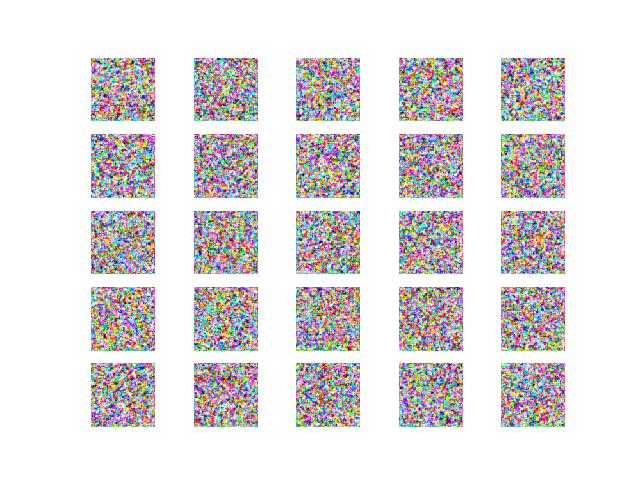

In [0]:
from IPython.display import Image
Image("images/indian_cars_0.png")

## GAN Generated Images after 500 epochs

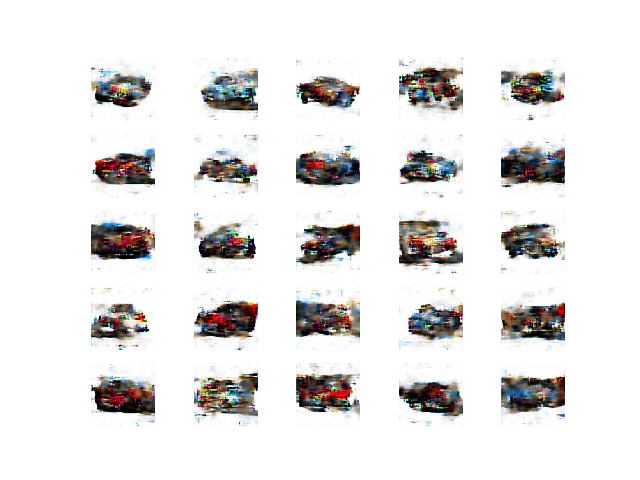

In [0]:
from IPython.display import Image
Image("images/indian_cars_500.png")

## GAN Generated Images after 1000 epochs

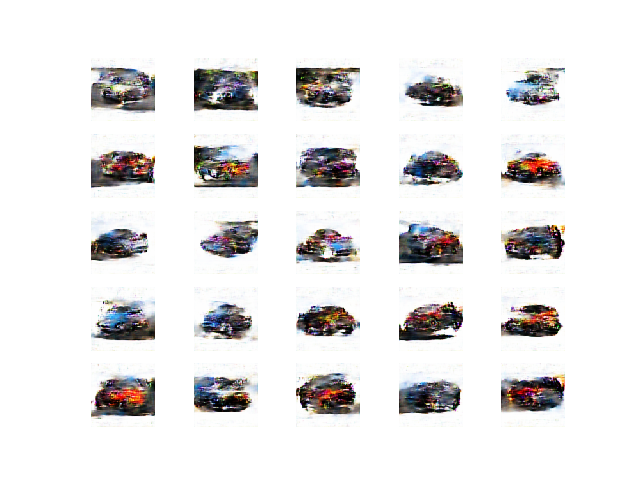

In [0]:
from IPython.display import Image
Image("images/indian_cars_1000.png")

## GAN Generated Images after 2000 epochs

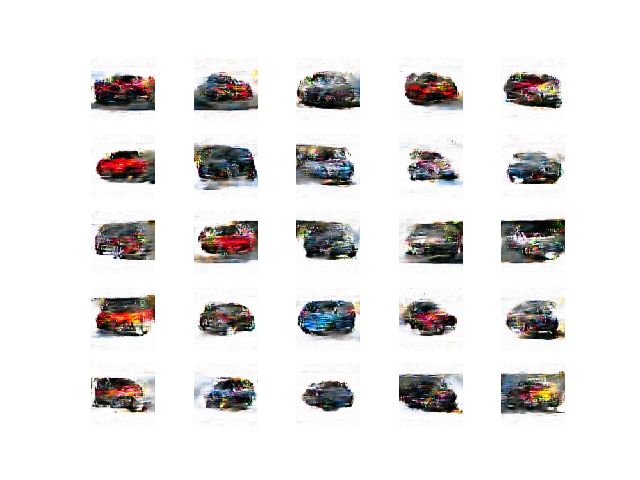

In [0]:
from IPython.display import Image
Image("images/indian_cars_2000.png")

## GAN Generated Images after 3000 epochs


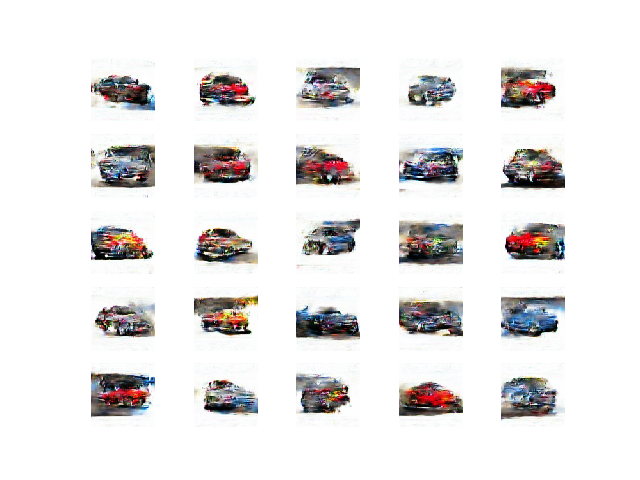

In [0]:
from IPython.display import Image
Image("images/indian_cars_3000.png")

## GAN Generated Images after 4000 epochs

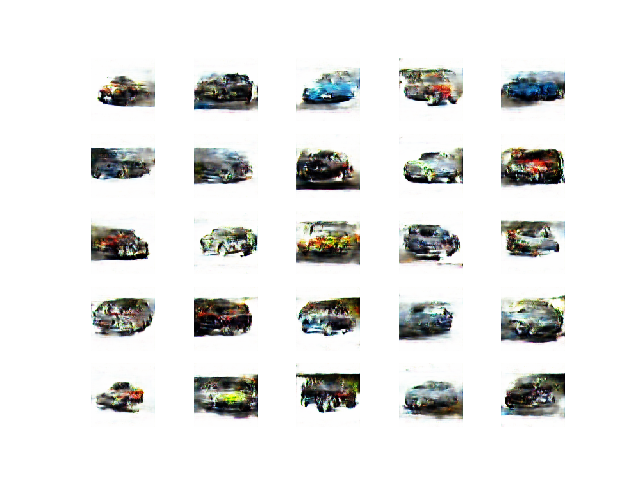

In [0]:
from IPython.display import Image
Image("images/indian_cars_4000.png")

## GAN generated Images after 4950 epochs

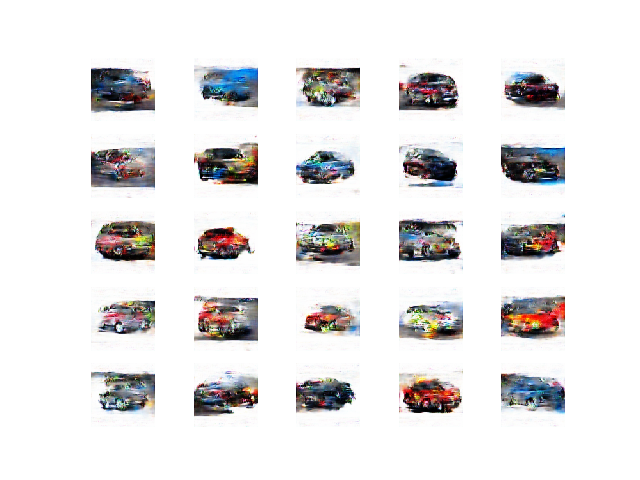

In [0]:
from IPython.display import Image
Image("images/indian_cars_4950.png")

## Observation:

In this assignment,we have trained Indian Car Images using DCGAN and got generated images which is of resonable newer car images. More training can be done to improve quality of images